## Library Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
# print(os.listdir(" "))

## Import the datasets
- train_identity has 
- train_transaction has

In [2]:
df_id = pd.read_csv("train_identity.csv")
df_trans = pd.read_csv("train_transaction.csv")

In [3]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

In [4]:
## REducing memory
df_trans = reduce_mem_usage(df_trans)
df_id = reduce_mem_usage(df_id)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)


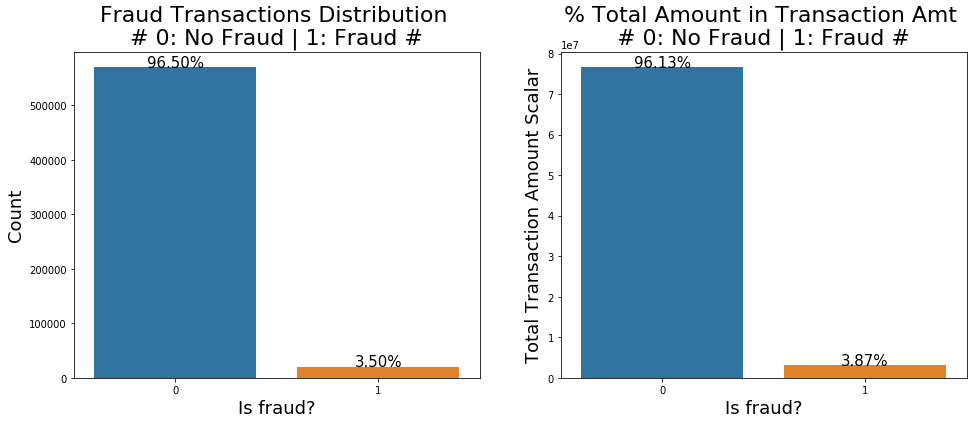

In [5]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
total = len(df_trans)
total_amt = df_trans.groupby(['isFraud'])['TransactionAmt'].sum().sum()
plt.figure(figsize=(16,6))

plt.subplot(121)
g = sns.countplot(x='isFraud', data=df_trans, )
g.set_title("Fraud Transactions Distribution \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g.set_xlabel("Is fraud?", fontsize=18)
g.set_ylabel('Count', fontsize=18)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=15) 

perc_amt = (df_trans.groupby(['isFraud'])['TransactionAmt'].sum())
perc_amt = perc_amt.reset_index()
plt.subplot(122)
g1 = sns.barplot(x='isFraud', y='TransactionAmt',  dodge=True, data=perc_amt)
g1.set_title("% Total Amount in Transaction Amt \n# 0: No Fraud | 1: Fraud #", fontsize=22)
g1.set_xlabel("Is fraud?", fontsize=18)
g1.set_ylabel('Total Transaction Amount Scalar', fontsize=18)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total_amt * 100),
            ha="center", fontsize=15) 
    
plt.show()

In [6]:
df_trans['TransactionAmt'] = df_trans['TransactionAmt'].astype(float)
print("Transaction Amounts Quantiles:")
print(df_trans['TransactionAmt'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))

Transaction Amounts Quantiles:
0.010       9.242188
0.025      14.500000
0.100      25.953125
0.250      43.312500
0.500      68.750000
0.750     125.000000
0.900     275.250000
0.975     648.262500
0.990    1104.000000
Name: TransactionAmt, dtype: float64


/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



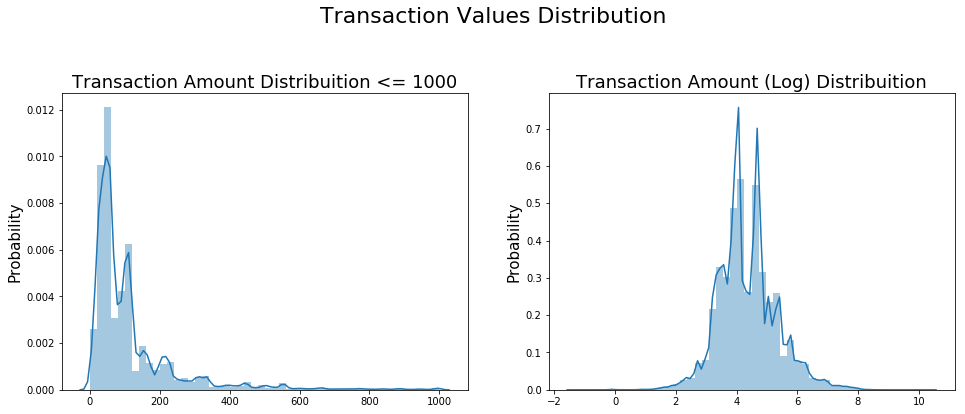

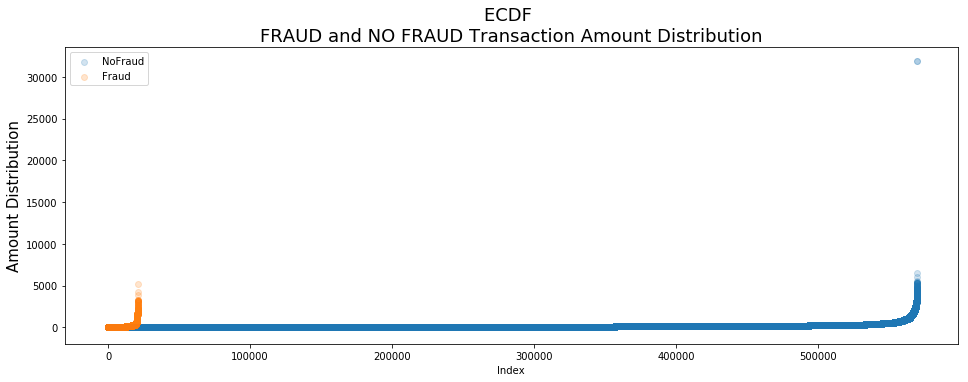

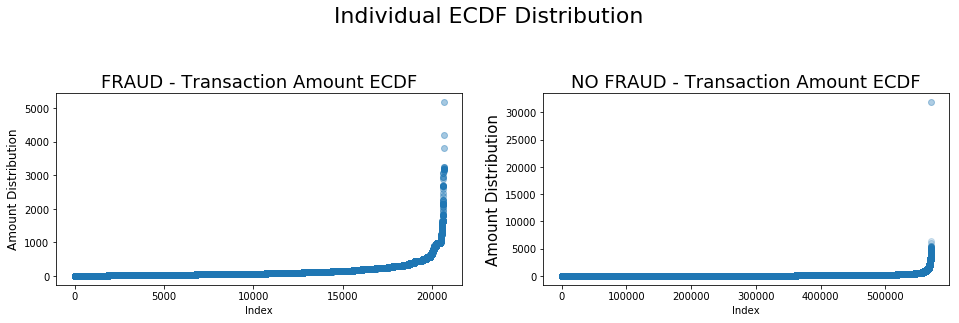

In [7]:
plt.figure(figsize=(16,12))
plt.suptitle('Transaction Values Distribution', fontsize=22)
plt.subplot(221)
g = sns.distplot(df_trans[df_trans['TransactionAmt'] <= 1000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 1000", fontsize=18)
g.set_xlabel("")
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.distplot(np.log(df_trans['TransactionAmt']))
g1.set_title("Transaction Amount (Log) Distribuition", fontsize=18)
g1.set_xlabel("")
g1.set_ylabel("Probability", fontsize=15)

plt.figure(figsize=(16,12))


plt.subplot(212)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g4 = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("ECDF \nFRAUD and NO FRAUD Transaction Amount Distribution", fontsize=18)
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Amount Distribution", fontsize=15)
g4 = plt.legend()

plt.figure(figsize=(16,12))

plt.subplot(321)
g = plt.scatter(range(df_trans[df_trans['isFraud'] == 1].shape[0]), 
                 np.sort(df_trans[df_trans['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("FRAUD - Transaction Amount ECDF", fontsize=18)
plt.xlabel("Index")
plt.ylabel("Amount Distribution", fontsize=12)

plt.subplot(322)
g1 = plt.scatter(range(df_trans[df_trans['isFraud'] == 0].shape[0]),
                 np.sort(df_trans[df_trans['isFraud'] == 0]['TransactionAmt'].values), 
                 label='NoFraud', alpha=.2)
g1= plt.title("NO FRAUD - Transaction Amount ECDF", fontsize=18)
g1 = plt.xlabel("Index")
g1 = plt.ylabel("Amount Distribution", fontsize=15)

plt.suptitle('Individual ECDF Distribution', fontsize=22)

plt.show()

In [8]:
print(pd.concat([df_trans[df_trans['isFraud'] == 1]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index(), 
                 df_trans[df_trans['isFraud'] == 0]['TransactionAmt']\
                 .quantile([.01, .1, .25, .5, .75, .9, .99])\
                 .reset_index()],
                axis=1, keys=['Fraud', "No Fraud"]))

  Fraud                No Fraud               
  index TransactionAmt    index TransactionAmt
0  0.01       6.739453     0.01       9.511875
1  0.10      18.937500     0.10      26.312500
2  0.25      35.031250     0.25      43.968750
3  0.50      75.000000     0.50      68.500000
4  0.75     161.000000     0.75     120.000000
5  0.90     335.000000     0.90     267.100000
6  0.99     994.000000     0.99    1104.000000


In [9]:
CalcOutliers(df_trans['TransactionAmt'])

Identified lowest outliers: 0
Identified upper outliers: 10097
Total outlier observations: 10097
Non-outlier observations: 580443
Total percentual of Outliers:  1.7395


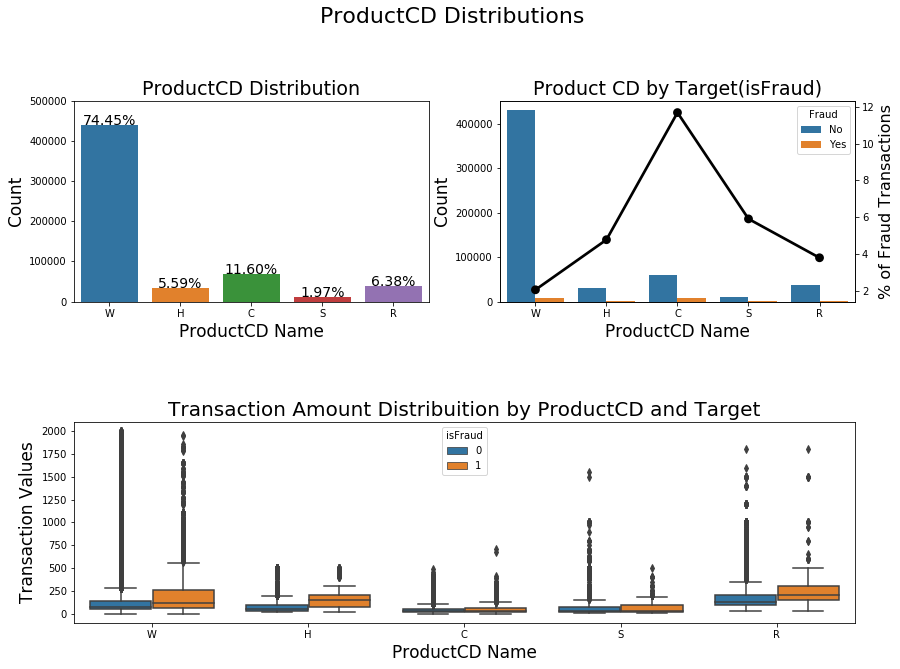

In [10]:
tmp = pd.crosstab(df_trans['ProductCD'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('ProductCD Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='ProductCD', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])

g.set_title("ProductCD Distribution", fontsize=19)
g.set_xlabel("ProductCD Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)

g1.set_title("Product CD by Target(isFraud)", fontsize=19)
g1.set_xlabel("ProductCD Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxplot(x='ProductCD', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Transaction Amount Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("ProductCD Name", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [11]:
## Knowning the Card Features
resumetable(df_trans[['card1', 'card2', 'card3','card4', 'card5', 'card6']])

Dataset Shape: (590540, 6)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,card1,int16,0,13553,13926,2755,4663,9.97
1,card2,float16,8933,500,NaN,404,490,6.32
2,card3,float16,1565,114,150,150,150,0.68
3,card4,object,1577,4,discover,mastercard,visa,1.09
4,card5,float16,4259,119,142,102,166,2.66
5,card6,object,1571,4,credit,credit,debit,0.82


In [12]:
print("Card Features Quantiles: ")
print(df_trans[['card1', 'card2', 'card3', 'card5']].quantile([0.01, .025, .1, .25, .5, .75, .975, .99]))

Card Features Quantiles: 
         card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0


/glob/intel-python/versions/2019u2/intelpython3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



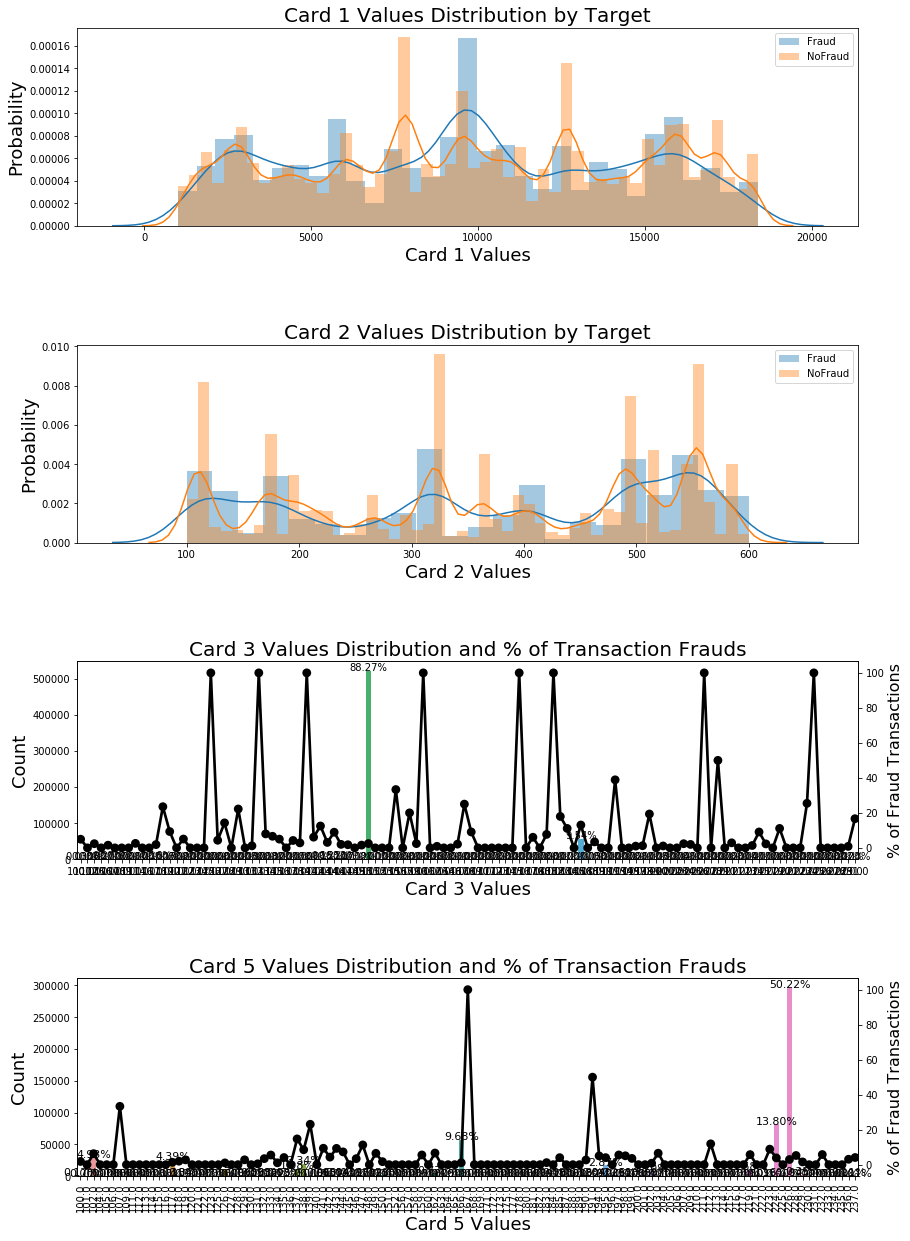

In [13]:
tmp = pd.crosstab(df_trans['card3'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

tmp2 = pd.crosstab(df_trans['card5'], df_trans['isFraud'], normalize='index') * 100
tmp2 = tmp2.reset_index()
tmp2.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,22))

plt.subplot(411)
g = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card1'], label='Fraud')
g = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card1'], label='NoFraud')
g.legend()
g.set_title("Card 1 Values Distribution by Target", fontsize=20)
g.set_xlabel("Card 1 Values", fontsize=18)
g.set_ylabel("Probability", fontsize=18)

plt.subplot(412)
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 1]['card2'].dropna(), label='Fraud')
g1 = sns.distplot(df_trans[df_trans['isFraud'] == 0]['card2'].dropna(), label='NoFraud')
g1.legend()
g1.set_title("Card 2 Values Distribution by Target", fontsize=20)
g1.set_xlabel("Card 2 Values", fontsize=18)
g1.set_ylabel("Probability", fontsize=18)

plt.subplot(413)
g2 = sns.countplot(x='card3', data=df_trans, order=list(tmp.card3.values))
g22 = g2.twinx()
gg2 = sns.pointplot(x='card3', y='Fraud', data=tmp, 
                    color='black', order=list(tmp.card3.values))
gg2.set_ylabel("% of Fraud Transactions", fontsize=16)
g2.set_title("Card 3 Values Distribution and % of Transaction Frauds", fontsize=20)
g2.set_xlabel("Card 3 Values", fontsize=18)
g2.set_ylabel("Count", fontsize=18)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
            height + 25,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

plt.subplot(414)
g3 = sns.countplot(x='card5', data=df_trans, order=list(tmp2.card5.values))
g3t = g3.twinx()
g3t = sns.pointplot(x='card5', y='Fraud', data=tmp2, 
                    color='black', order=list(tmp2.card5.values))
g3t.set_ylabel("% of Fraud Transactions", fontsize=16)
g3.set_title("Card 5 Values Distribution and % of Transaction Frauds", fontsize=20)
g3.set_xticklabels(g3.get_xticklabels(),rotation=90)
g3.set_xlabel("Card 5 Values", fontsize=18)
g3.set_ylabel("Count", fontsize=18)
for p in g3.patches:
    height = p.get_height()
    g3.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.6, top = 0.85)


plt.show()

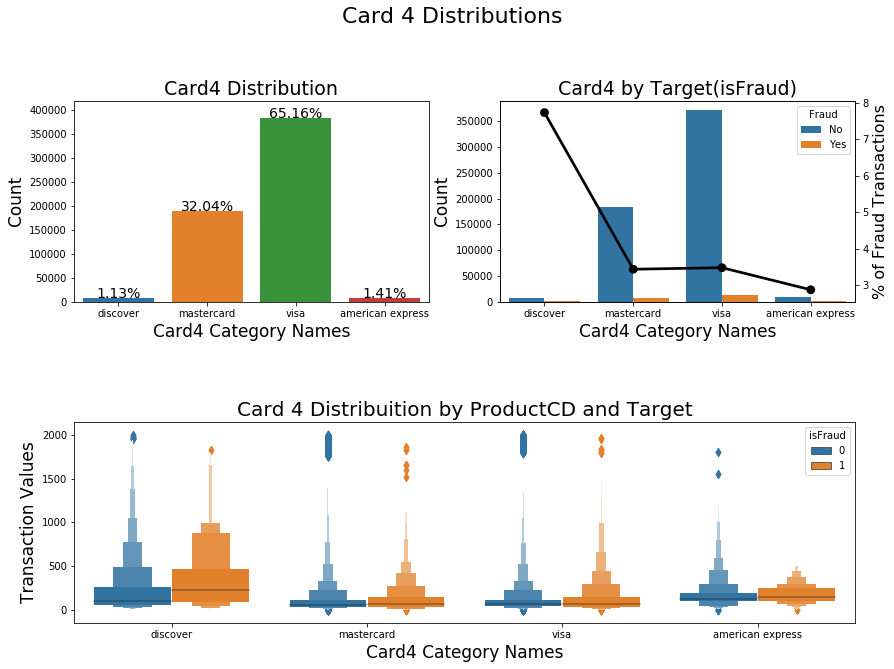

In [14]:
tmp = pd.crosstab(df_trans['card4'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 4 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card4', data=df_trans)
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card4 Distribution", fontsize=19)
g.set_ylim(0,420000)
g.set_xlabel("Card4 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 


plt.subplot(222)
g1 = sns.countplot(x='card4', hue='isFraud', data=df_trans)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card4', y='Fraud', data=tmp, 
                   color='black', legend=False, 
                   order=['discover', 'mastercard', 'visa', 'american express'])
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card4 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card4 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card4', y='TransactionAmt', hue='isFraud', 
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 4 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card4 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

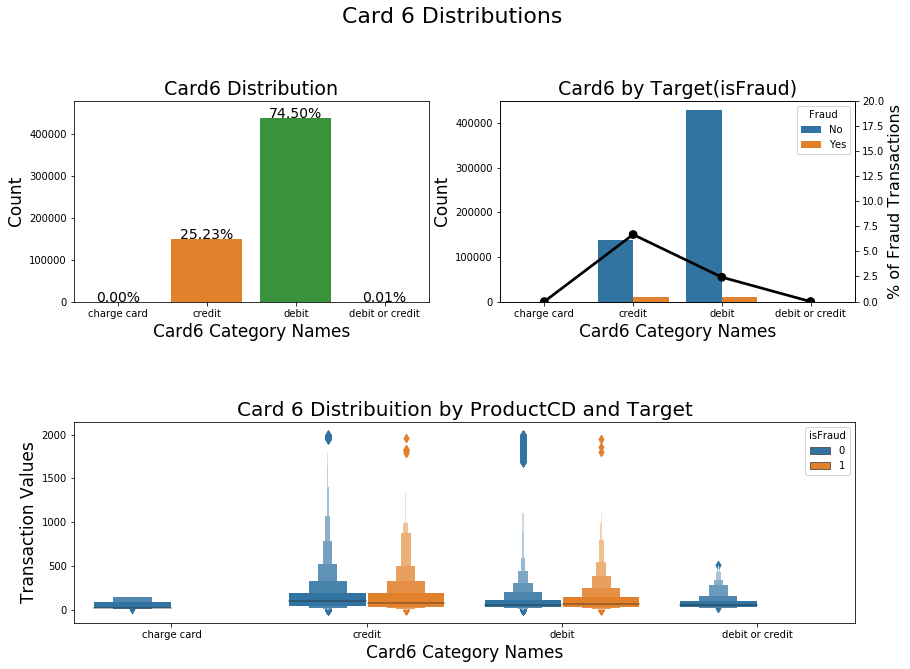

In [15]:
tmp = pd.crosstab(df_trans['card6'], df_trans['isFraud'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Card 6 Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='card6', data=df_trans, order=list(tmp.card6.values))
# plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
g.set_title("Card6 Distribution", fontsize=19)
g.set_ylim(0,480000)
g.set_xlabel("Card6 Category Names", fontsize=17)
g.set_ylabel("Count", fontsize=17)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center",fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='card6', hue='isFraud', data=df_trans, order=list(tmp.card6.values))
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='card6', y='Fraud', data=tmp, order=list(tmp.card6.values),
                   color='black', legend=False, )
gt.set_ylim(0,20)
gt.set_ylabel("% of Fraud Transactions", fontsize=16)
g1.set_title("Card6 by Target(isFraud)", fontsize=19)
g1.set_xlabel("Card6 Category Names", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='card6', y='TransactionAmt', hue='isFraud', order=list(tmp.card6.values),
              data=df_trans[df_trans['TransactionAmt'] <= 2000] )
g3.set_title("Card 6 Distribuition by ProductCD and Target", fontsize=20)
g3.set_xlabel("Card6 Category Names", fontsize=17)
g3.set_ylabel("Transaction Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

In [16]:
for col in ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']:
    df_trans[col] = df_trans[col].fillna("Miss")
    
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.figure(figsize=(20,5))
    plt.suptitle(f'{col} Distributions ', fontsize=22)

    plt.subplot(121)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    # plt.legend(title='Fraud', loc='upper center', labels=['No', 'Yes'])
    g.set_title(f"{col} Distribution\nCound and %Fraud by each category", fontsize=18)
    g.set_ylim(0,400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,20)
    gt.set_ylabel("% of Fraud Transactions", fontsize=16)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=14) 
        
    perc_amt = (df_trans.groupby(['isFraud',col])['TransactionAmt'].sum() / total_amt * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    plt.subplot(122)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', 
                     data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,5)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g1.set_title(f"{col} by Transactions dist", fontsize=18)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Amount(U$)", fontsize=16)
        
    plt.subplots_adjust(hspace=.4, wspace = 0.35, top = 0.80)
    
    plt.show()


In [17]:
print("Card Features Quantiles: ")
print(df_trans[['addr1', 'addr2']].quantile([0.01, .025, .1, .25, .5, .75, .90,.975, .99]))

Card Features Quantiles: 
       addr1  addr2
0.010  123.0   87.0
0.025  123.0   87.0
0.100  177.0   87.0
0.250  204.0   87.0
0.500  299.0   87.0
0.750  330.0   87.0
0.900  441.0   87.0
0.975  498.0   87.0
0.990  512.0   87.0


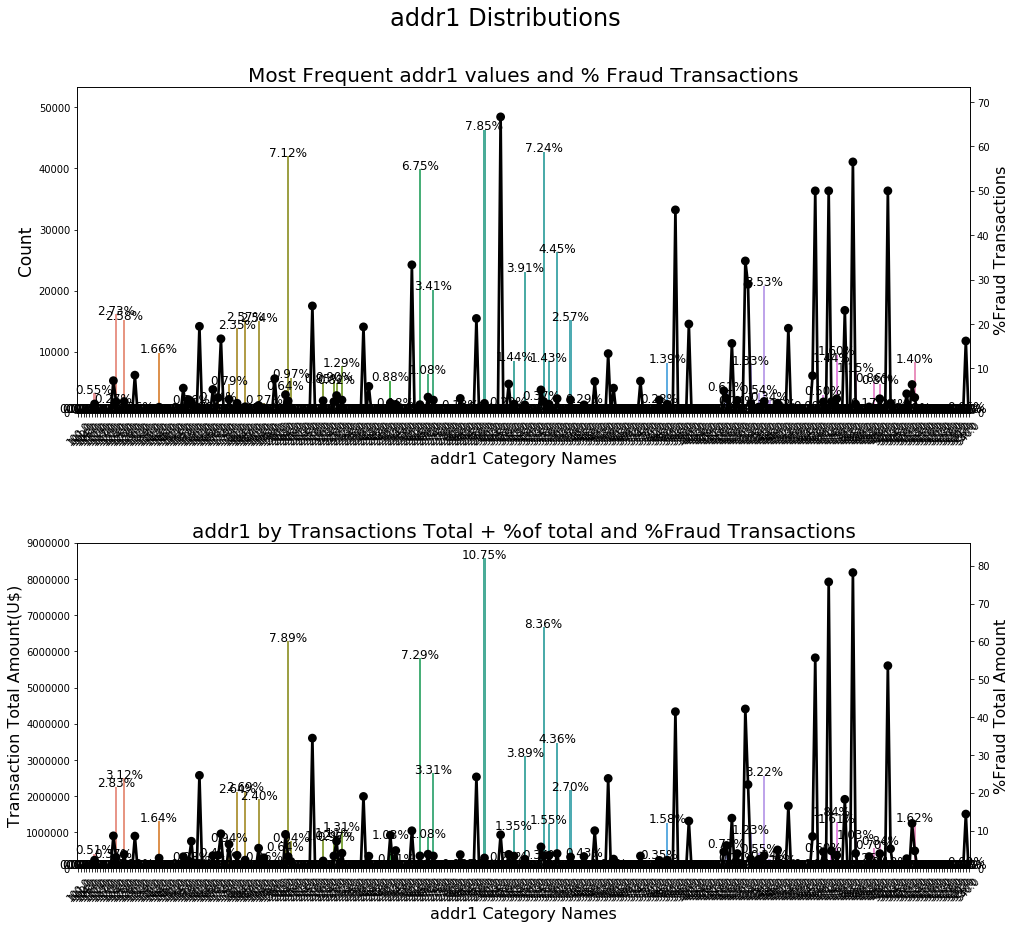

In [18]:
 def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(df_trans, 'addr1')

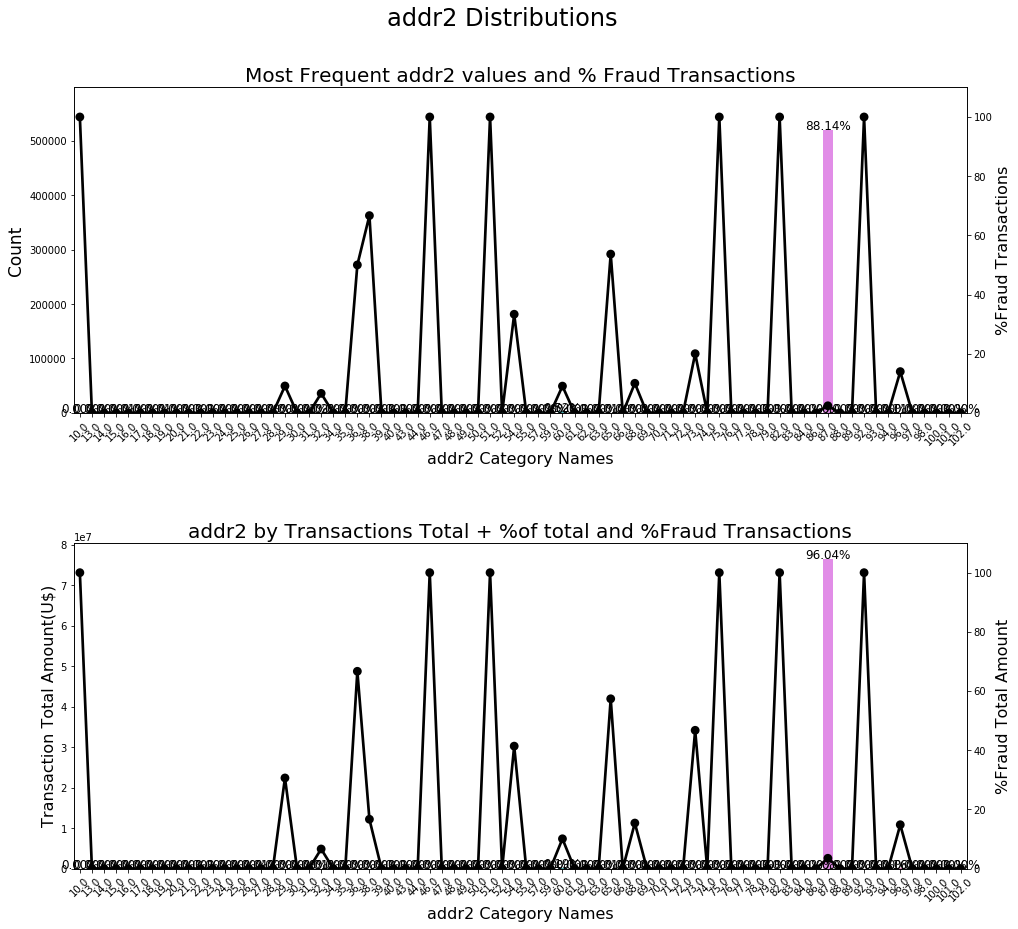

In [19]:
ploting_cnt_amt(df_trans, 'addr2')

In [20]:
df_trans.loc[df_trans['P_emaildomain'].isin(['gmail.com', 'gmail']),'P_emaildomain'] = 'Google'

df_trans.loc[df_trans['P_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                         'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                         'yahoo.es']), 'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.P_emaildomain.isin(df_trans.P_emaildomain\
                                         .value_counts()[df_trans.P_emaildomain.value_counts() <= 500 ]\
                                         .index), 'P_emaildomain'] = "Others"
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

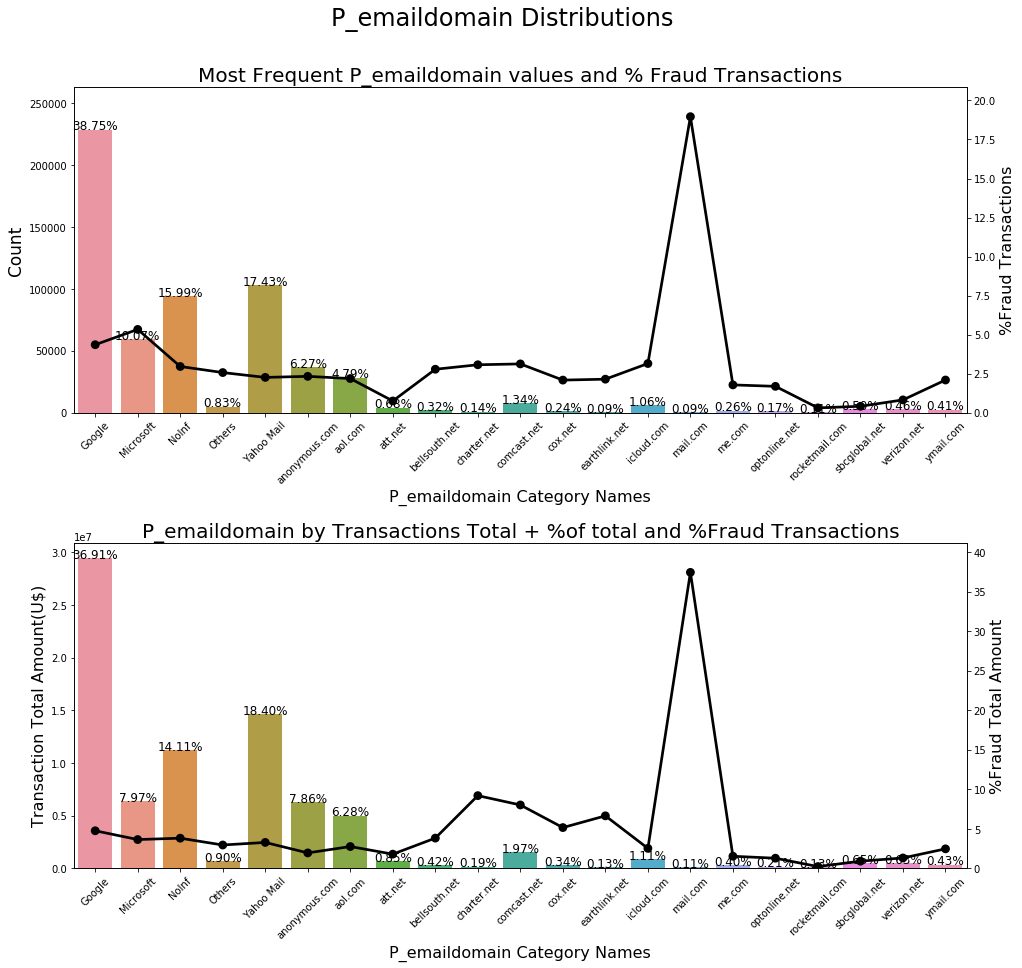

In [21]:
ploting_cnt_amt(df_trans, 'P_emaildomain')

In [22]:
df_trans.loc[df_trans['R_emaildomain'].isin(['gmail.com', 'gmail']),'R_emaildomain'] = 'Google'

df_trans.loc[df_trans['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk',
                                             'yahoo.co.jp', 'yahoo.de', 'yahoo.fr',
                                             'yahoo.es']), 'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                             'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                             'outlook.es', 'live.com', 'live.fr',
                                             'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'
df_trans.loc[df_trans.R_emaildomain.isin(df_trans.R_emaildomain\
                                         .value_counts()[df_trans.R_emaildomain.value_counts() <= 300 ]\
                                         .index), 'R_emaildomain'] = "Others"
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

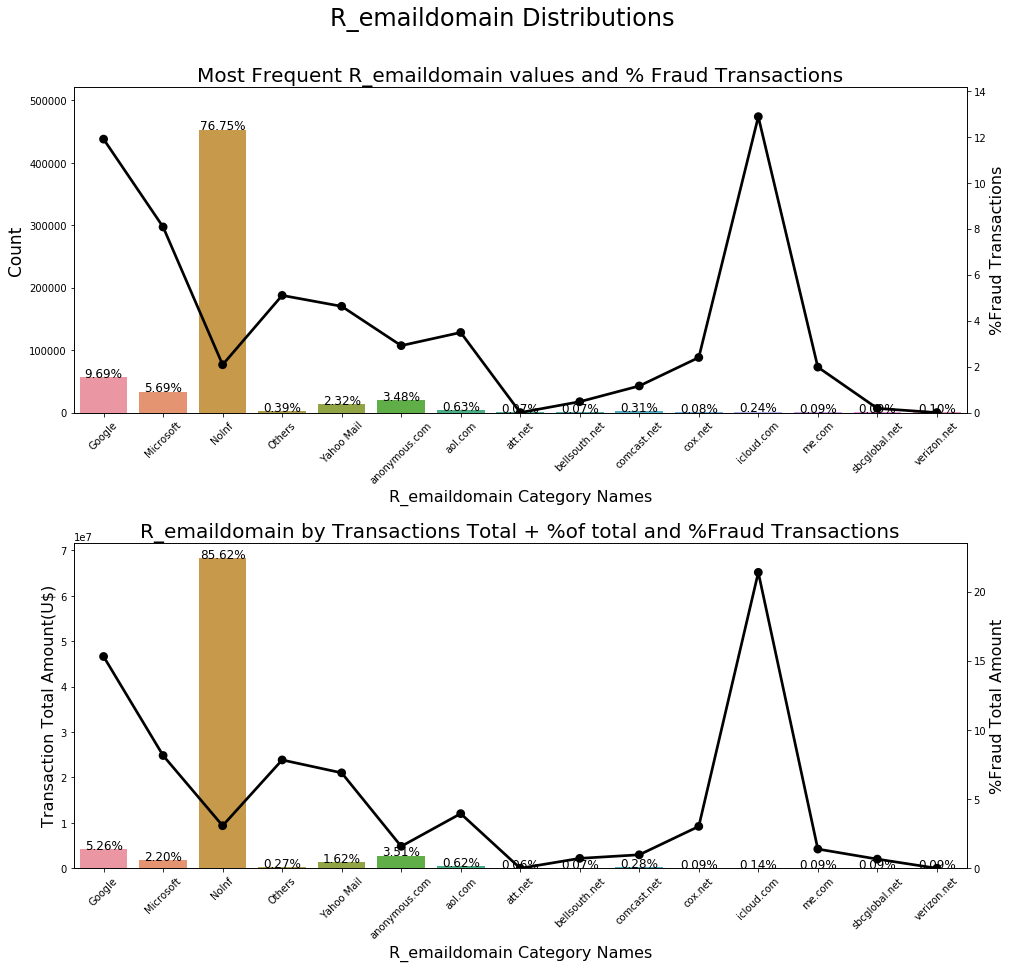

In [23]:
ploting_cnt_amt(df_trans, 'R_emaildomain')

In [24]:
resumetable(df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']])

Dataset Shape: (590540, 14)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,C1,float16,0,1495,1.0,1.0,1.0,2.72
1,C2,float16,0,1167,1.0,1.0,1.0,2.75
2,C3,float16,0,27,0.0,0.0,0.0,0.04
3,C4,float16,0,1223,0.0,0.0,0.0,1.12
4,C5,float16,0,319,0.0,0.0,0.0,2.06
5,C6,float16,0,1291,1.0,1.0,1.0,2.52
6,C7,float16,0,1069,0.0,0.0,0.0,0.71
7,C8,float16,0,1130,0.0,0.0,0.0,1.25
8,C9,float16,0,205,1.0,0.0,1.0,2.62
9,C10,float16,0,1122,0.0,0.0,0.0,1.23


In [25]:
df_trans[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
                      'C9', 'C10', 'C11', 'C12', 'C13', 'C14']].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0,590540.0
mean,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.0,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


In [26]:
df_trans.loc[df_trans.C1.isin(df_trans.C1\
                              .value_counts()[df_trans.C1.value_counts() <= 400 ]\
                              .index), 'C1'] = "Others"

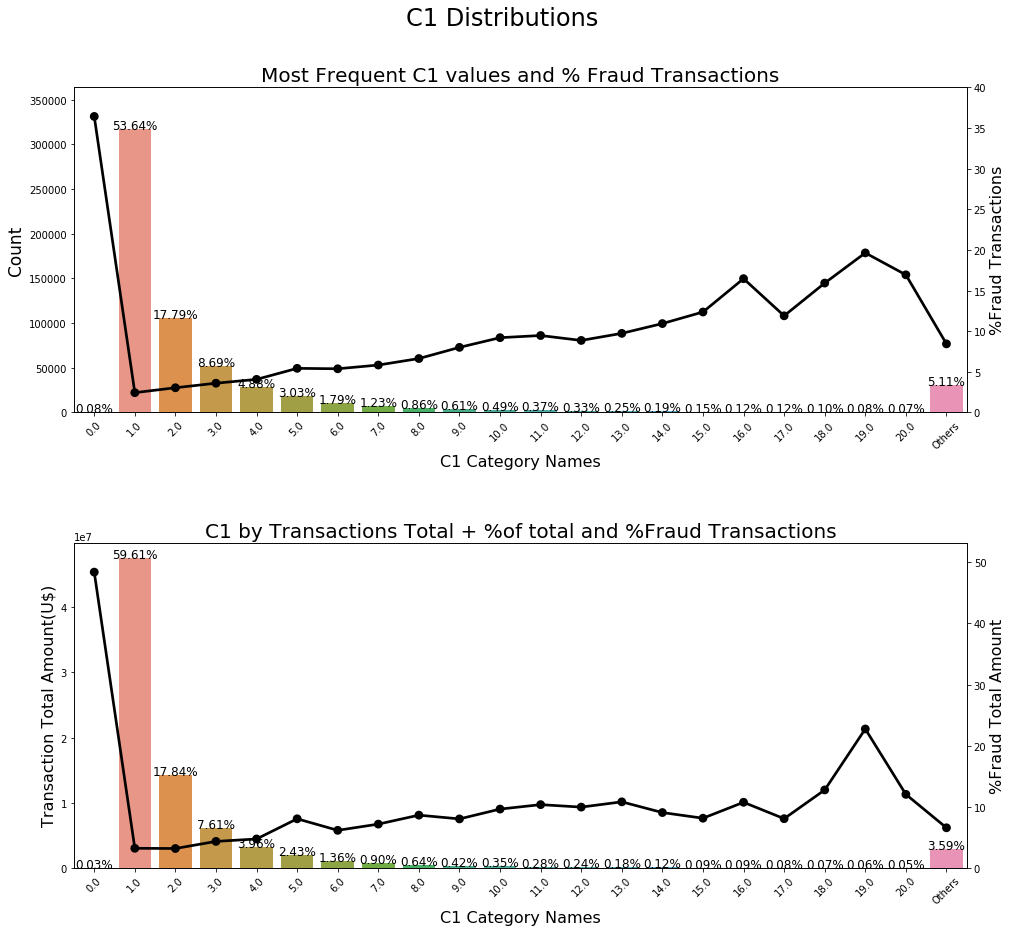

In [27]:
ploting_cnt_amt(df_trans, 'C1')

In [28]:
df_trans.loc[df_trans.C2.isin(df_trans.C2\
                              .value_counts()[df_trans.C2.value_counts() <= 350 ]\
                              .index), 'C2'] = "Others"

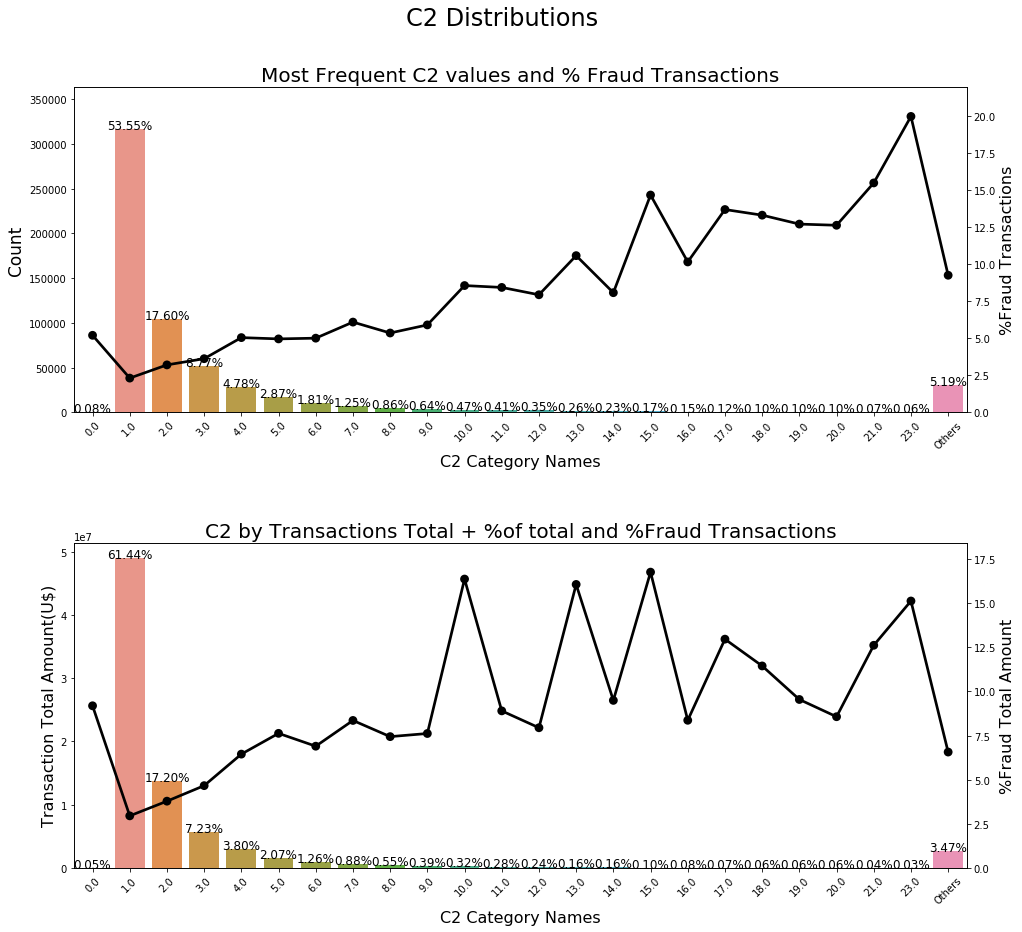

In [29]:
ploting_cnt_amt(df_trans, 'C2')

In [30]:

import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
df_trans["Date"] = df_trans['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek
df_trans['_Hours'] = df_trans['Date'].dt.hour
df_trans['_Days'] = df_trans['Date'].dt.day

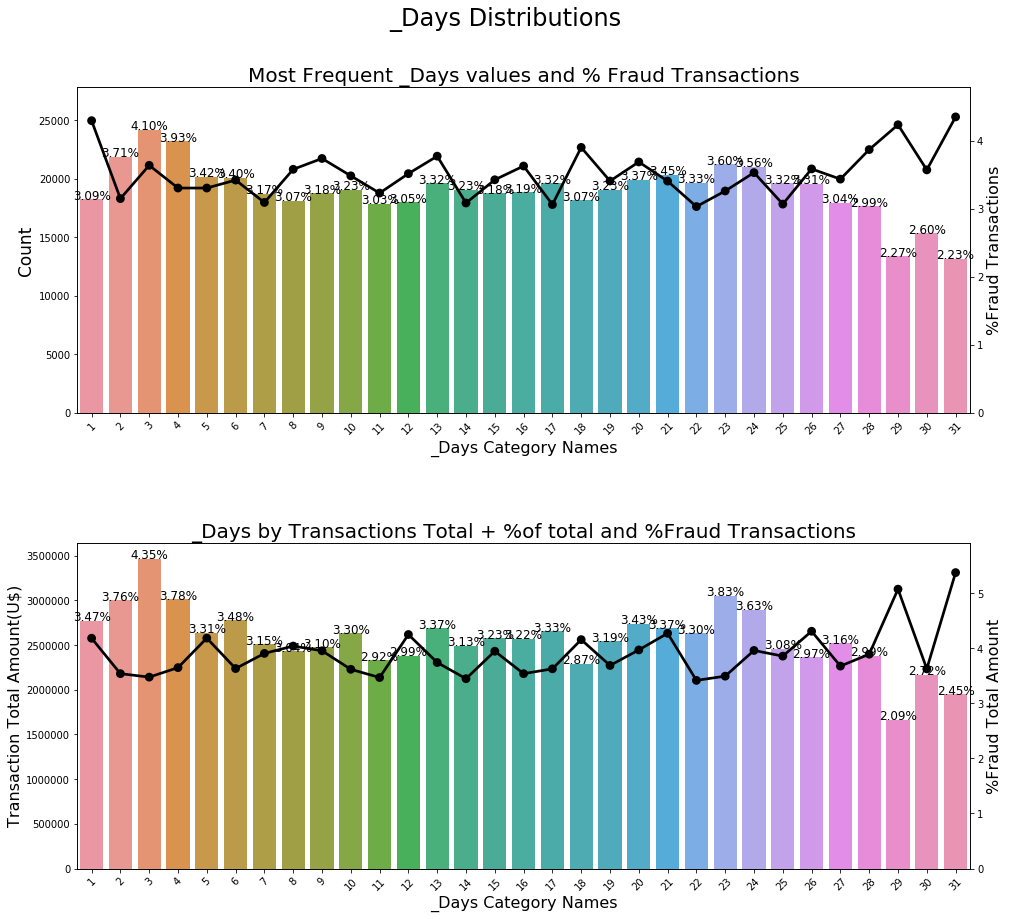

In [31]:
ploting_cnt_amt(df_trans, '_Days')

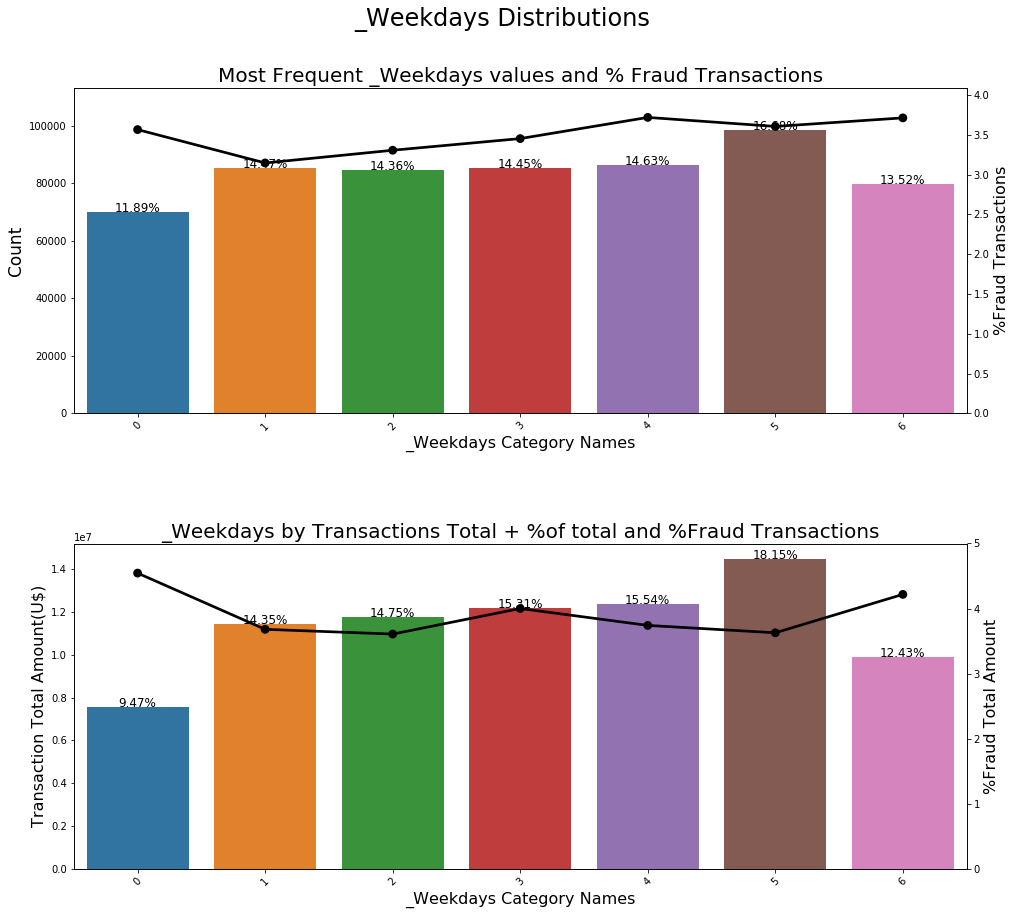

In [32]:
ploting_cnt_amt(df_trans, '_Weekdays')

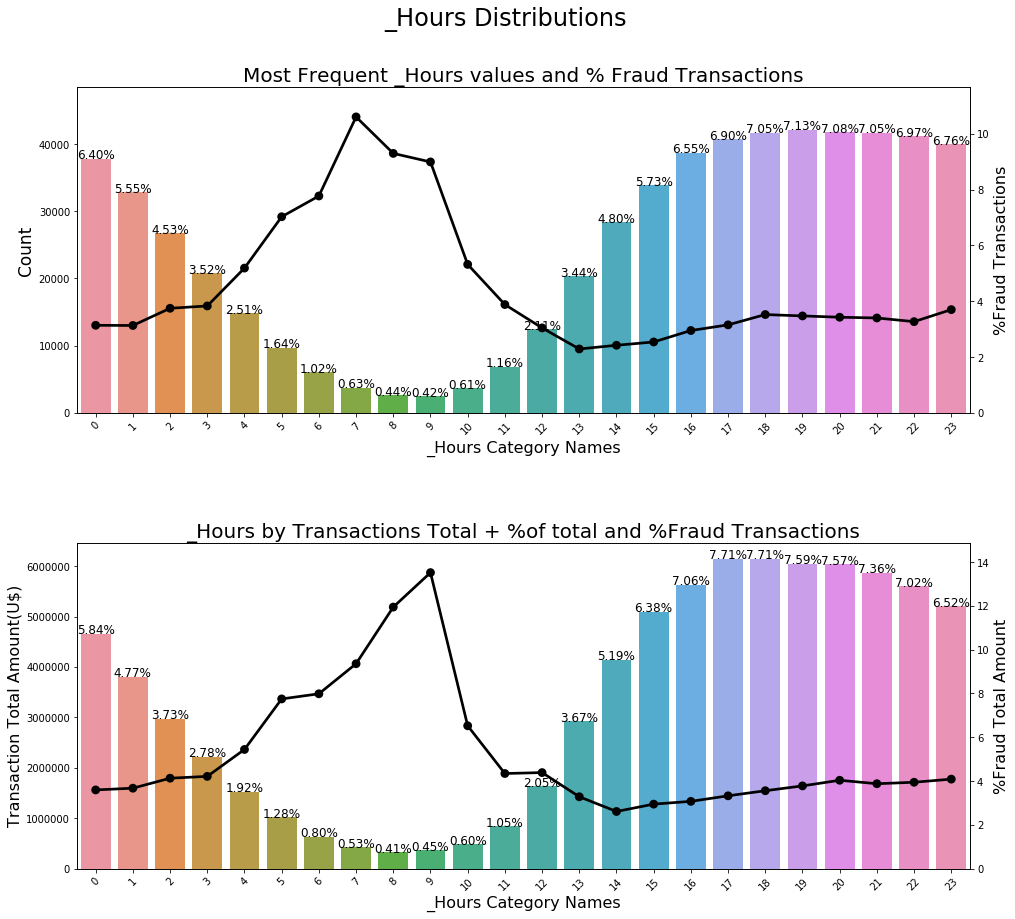

In [33]:
ploting_cnt_amt(df_trans, '_Hours')

#### IMPORTING NECESSARY PACKAGES

In [36]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
# import catboost
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.gridspec as gridspec
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import gc
gc.enable()

import logging
logger = logging.getLogger()

logger.setLevel(logging.DEBUG)

import os

print ("Ready!")

Ready!


#### DECLARING MOST IMPORTANT FEATURES FROM THE GIVEN DATASET
#### WHICH WILL BE USED IN EXECUTION OF THE PROGRAM

In [37]:
import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

#### IMPORTING DATA

In [38]:
%%time

X_train = pd.read_csv('train_transaction.csv',index_col='TransactionID', usecols=cols+['isFraud'])
train_id = pd.read_csv('train_identity.csv',index_col='TransactionID')
train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

# LOAD TEST
X_test = pd.read_csv('test_transaction.csv',index_col='TransactionID', usecols=cols)
test_id = pd.read_csv('test_identity.csv',index_col='TransactionID')
test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

# TARGET
y_train = train['isFraud'].astype("uint8").copy()

del train_id, test_id, X_train['isFraud'], X_train, X_test; 
x = gc.collect()


# PRINT STATUS
print('Train shape',train.shape,'test shape',test.shape)

Train shape (590540, 214) test shape (506691, 213)
CPU times: user 24 s, sys: 2.52 s, total: 26.5 s
Wall time: 18.7 s


#### TRANSFORMATION OF DATA TO DESIRED FORMAT

In [17]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails).astype('object')
    train[c + '_bin'] = train[c].map(emails).astype('object')
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1]).astype('object')
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1]).astype('object')
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us').astype('object')
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us').astype('object')
    
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

In [39]:
%%time
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

# del train, test
gc.collect()

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values))  

CPU times: user 6min 28s, sys: 5.2 s, total: 6min 33s
Wall time: 1min 6s


In [5]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [18]:
train['TransactionAmt'] = np.log(train['TransactionAmt'])
test['TransactionAmt'] = np.log(test['TransactionAmt'])

#### MEMORY REDUCTION

In [40]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.5 µs


In [41]:
%%time
X_train = reduce_mem_usage2(X_train)
X_test = reduce_mem_usage2(X_test)

Memory usage of dataframe is 984.17 MB
Memory usage after optimization is: 264.42 MB
Decreased by 73.1%
Memory usage of dataframe is 827.27 MB
Memory usage after optimization is: 212.62 MB
Decreased by 74.3%
CPU times: user 2min 20s, sys: 1min 46s, total: 4min 6s
Wall time: 20.6 s


In [8]:
X_train.shape

(590540, 213)

In [9]:
X_test.head(3)

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
3663549,18403224,31.953125,4,10409,111.0,150.0,4,226.0,2,170.0,...,136,NaN,461,4,2,2,2,2,2,2740
3663550,18403263,49.000000,4,4272,111.0,150.0,4,226.0,2,299.0,...,136,NaN,461,4,2,2,2,2,2,2740
3663551,18403310,171.000000,4,4476,574.0,150.0,4,226.0,2,472.0,...,136,NaN,461,4,2,2,2,2,2,2740


#### MODEL FITTING ON DATA

In [42]:
# drop_col = ['TransactionDT', 'V3h00', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125', 'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110', 'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 'V284', 'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119', 'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117', 'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']
drop_col = ['TransactionDT']
X_train.drop(drop_col,axis=1, inplace=True)
X_test.drop(drop_col, axis=1, inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,136,NaN,461,4,2,2,2,2,2,2740
2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565


**Fill NaN**

In [43]:
X_train.fillna(-1,inplace=True)
X_test.fillna(-1,inplace=True)
X_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,68.5,4,13926,-1.0,150.0,1,142.0,1,315.0,87.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987001,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987002,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987003,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,...,136,-1.0,461,4,2,2,2,2,2,2740
2987004,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,...,162,32.0,268,3,1,0,1,1,1,1565


#### IMPORTING MODELS

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [46]:
X_train_ts, X_test_ts, y_train_ts, y_test_ts = tts(X_train, y_train, test_size=0.3, stratify=y_train, random_state=21)

In [ ]:
# model=LogisticRegression()

# model.fit(X_train_ts, y_train_ts)
# print("TEST Accuracy Score: ",model.score(X_test_ts, y_test_ts))
# print("Train Accuracy Score: ",model.score(X_train_ts, y_train_ts))

# y_pred_ts=model.predict(X_test_ts)
# print("AUC Score\t\t: ",roc_auc_score(y_test_ts,y_pred_ts))

# print("Confusion Matrix\t: \n",confusion_matrix(y_test_ts,y_pred_ts))
# print("F1 score\t\t: ", f1_score(y_test_ts, y_pred_ts))
# print("Recall\t\t\t: ", recall_score(y_test_ts, y_pred_ts))
# print("Precsion Score\t\t: ",precision_score(y_test_ts, y_pred_ts))

In [47]:
model=DecisionTreeClassifier()

model.fit(X_train_ts, y_train_ts)
print("TEST Accuracy Score: ",model.score(X_test_ts, y_test_ts))
print("Train Accuracy Score: ",model.score(X_train_ts, y_train_ts))

y_pred_ts=model.predict(X_test_ts)
print("AUC Score\t\t: ",roc_auc_score(y_test_ts,y_pred_ts))

print("Confusion Matrix\t: \n",confusion_matrix(y_test_ts,y_pred_ts))
print("F1 score\t\t: ", f1_score(y_test_ts, y_pred_ts))
print("Recall\t\t\t: ", recall_score(y_test_ts, y_pred_ts))
print("Precsion Score\t\t: ",precision_score(y_test_ts, y_pred_ts))

TEST Accuracy Score:  0.9677470337882842
Train Accuracy Score:  0.9999927427197384
AUC Score		:  0.7900431485050603
Confusion Matrix	: 
 [[167735   3228]
 [  2486   3713]]
F1 score		:  0.5651445966514459
Recall			:  0.5989675754153896
Precsion Score		:  0.5349373289151419


In [48]:
model=RandomForestClassifier()

model.fit(X_train_ts, y_train_ts)
print("TEST Accuracy Score: ",model.score(X_test_ts, y_test_ts))
print("Train Accuracy Score: ",model.score(X_train_ts, y_train_ts))

y_pred_ts=model.predict(X_test_ts)
print("AUC Score\t\t: ",roc_auc_score(y_test_ts,y_pred_ts))

print("Confusion Matrix\t: \n",confusion_matrix(y_test_ts,y_pred_ts))
print("F1 score\t\t: ", f1_score(y_test_ts, y_pred_ts))
print("Recall\t\t\t: ", recall_score(y_test_ts, y_pred_ts))
print("Precsion Score\t\t: ",precision_score(y_test_ts, y_pred_ts))

TEST Accuracy Score:  0.9804754970027433
Train Accuracy Score:  0.9969156558887992
AUC Score		:  0.7351508957914465
Confusion Matrix	: 
 [[170781    182]
 [  3277   2922]]
F1 score		:  0.6281844566268946
Recall			:  0.4713663494111954
Precsion Score		:  0.9413659793814433


#### HYPERPARAMETER TUNING

#### BEST MODEL IMPLEMENTATION

In [16]:
%%time
NFOLDS = 3
kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=123)

y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
  
for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    clf = xgb.XGBClassifier(
        n_estimators=2000,
        max_depth=12,
        learning_rate=0.02,
        subsample=0.8,
        colsample_bytree=0.4,
        eval_metric='auc',
        missing = -1,
        n_jobs=-1,
        n_threads=-1)
    
    X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
    y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    clf.fit(X_tr, y_tr)
    y_pred_train = clf.predict_proba(X_vl)[:,1]
    y_oof[val_idx] = y_pred_train
    print("FOLD: ",fold,' AUC {}'.format(roc_auc_score(y_vl, y_pred_train)))
    score += roc_auc_score(y_vl, y_pred_train) / NFOLDS
    y_preds+= clf.predict_proba(X_test)[:,1] / NFOLDS
    
    print("TEST Accuracy Score: ",clf.score(X_vl, y_vl))
    print("Train Accuracy Score: ",clf.score(X_tr, y_tr))
    y_pred=clf.predict(X_vl)
    print("AUC Score\t\t: ",roc_auc_score(y_vl,y_pred))

    print("Confusion Matrix\t: \n",confusion_matrix(y_vl,y_pred))
    print("F1 score\t\t: ", f1_score(y_vl, y_pred))
    print("Recall\t\t\t: ", recall_score(y_vl, y_pred))
    print("Precsion Score\t\t: ",precision_score(y_vl, y_pred))
    
    del X_tr, X_vl, y_tr, y_vl
    gc.collect()
    
    
print("\nMEAN AUC = {}".format(score))
print("OOF AUC = {}".format(roc_auc_score(y_train, y_oof)))

FOLD:  0  AUC 0.9685641204811852
TEST Accuracy Score:  0.9853744278551362
Train Accuracy Score:  0.9973685079490873
AUC Score		:  0.8024164885045584
Confusion Matrix	: 
 [[189796    163]
 [  2716   4172]]
F1 score		:  0.743473224627996
Recall			:  0.6056910569105691
Precsion Score		:  0.96239907727797
FOLD:  1  AUC 0.9718946232324392
TEST Accuracy Score:  0.9857706746864316
Train Accuracy Score:  0.9971907044321336
AUC Score		:  0.8054201105527393
Confusion Matrix	: 
 [[189834    125]
 [  2676   4212]]
F1 score		:  0.7504677060133629
Recall			:  0.6114982578397212
Precsion Score		:  0.9711782338021674
FOLD:  2  AUC 0.968381371036656
TEST Accuracy Score:  0.9850543064121191
Train Accuracy Score:  0.9973126336698045
AUC Score		:  0.7960648165758998
Confusion Matrix	: 
 [[189821    138]
 [  2804   4083]]
F1 score		:  0.7351458408354338
Recall			:  0.5928561057064033
Precsion Score		:  0.9673063255152807

MEAN AUC = 0.9696133715834268
OOF AUC = 0.9695913286713681
CPU times: user 7h 55s, sy